In [1]:
import pandas as pd
import numpy as np
from scipy import stats
# featuretools for automated feature engineering
import featuretools as ft
import math

# matplotlit and seaborn for visualizations
import matplotlib.pyplot as plt
# plt.rcParams['font.size'] = 22
import seaborn as sns

# Suppress warnings from pandas
import warnings
warnings.filterwarnings('ignore')

# modeling 
import lightgbm as lgb

# utilities
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import LabelEncoder
sns.set_style("darkgrid")
# memory management
import gc

In [2]:
import os
# 운영체제별 한글 폰트 설정
if os.name == 'posix': # Mac 환경 폰트 설정
    plt.rc('font', family='AppleGothic')
elif os.name == 'nt': # Windows 환경 폰트 설정
    plt.rc('font', family='Malgun Gothic')

plt.rc('axes', unicode_minus=False) # 마이너스 폰트 설정


# 글씨 선명하게 출력하는 설정
%config InlineBackend.figure_format = 'retina'

In [3]:
data1 = pd.read_csv("NHIS_OPEN_GJ_2017_100.csv", encoding='euc-kr')
data2 = pd.read_csv("NHIS_OPEN_GJ_2018_100.csv")

## 2017음주여부 날리고 2018음주여부 0으로 채우기

In [4]:
data1 = data1.dropna(axis=0, subset=['음주여부'])
data2 = data2.fillna({'음주여부':0})

## 데이터 합치고 필요한 속성만 저장

In [18]:
df = pd.concat([data1,data2]).reset_index(drop=True, inplace=False)

In [19]:
df = df.loc[:,['성별코드','연령대코드(5세단위)','신장(5Cm단위)','체중(5Kg단위)','허리둘레','수축기혈압',
       '이완기혈압', '식전혈당(공복혈당)','요단백', '혈청크레아티닌', '(혈청지오티)AST', '(혈청지오티)ALT', '감마지티피', '흡연상태',
       '음주여부']]

## 혈당 Null값 제거

In [20]:
df = df.dropna(axis=0, subset=['식전혈당(공복혈당)'])

## BMI 추가

In [21]:
BMI = round((df["체중(5Kg단위)"] / ((df["신장(5Cm단위)"]/100)**2)),2)
df['BMI'] = BMI

In [22]:
df

,성별코드,연령대코드(5세단위),신장(5Cm단위),체중(5Kg단위),허리둘레,수축기혈압,이완기혈압,식전혈당(공복혈당),요단백,혈청크레아티닌,(혈청지오티)AST,(혈청지오티)ALT,감마지티피,흡연상태,음주여부,BMI
0,1,8,170,75,90.0,120.0,80.0,99.0,1.0,1.0,21.0,35.0,40.0,1.0,1.0,25.95
1,1,7,180,80,89.0,130.0,82.0,106.0,1.0,0.9,20.0,36.0,27.0,3.0,0.0,24.69
2,1,9,165,75,91.0,120.0,70.0,98.0,1.0,0.9,47.0,32.0,68.0,1.0,0.0,27.55
3,1,11,175,80,91.0,145.0,87.0,95.0,1.0,1.1,29.0,34.0,18.0,1.0,0.0,26.12
4,1,11,165,60,80.0,138.0,82.0,101.0,1.0,0.8,19.0,12.0,25.0,1.0,0.0,22.04
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1999459,2,11,165,75,84.0,110.0,70.0,107.0,1.0,0.7,18.0,15.0,19.0,1.0,0.0,27.55
1999460,1,7,170,75,88.0,136.0,88.0,114.0,1.0,1.0,25.0,36.0,90.0,1.0,1.0,25.95
1999461,1,8,175,80,87.0,162.0,90.0,98.0,1.0,0.9,21.0,15.0,36.0,2.0,1.0,26.12
1999462,1,11,165,70,80.2,140.0,98.0,94.0,1.0,1.2,20.0,18.0,14.0,2.0,0.0,25.71


In [23]:
df.isnull().sum()

성별코드              0
연령대코드(5세단위)       0
신장(5Cm단위)         0
체중(5Kg단위)         0
허리둘레            671
수축기혈압            39
이완기혈압            39
식전혈당(공복혈당)        0
요단백            9271
혈청크레아티닌           4
(혈청지오티)AST        2
(혈청지오티)ALT        3
감마지티피             6
흡연상태            329
음주여부              0
BMI               0
dtype: int64

## null값 제거

In [24]:
df = df.dropna(axis = 0)
df

,성별코드,연령대코드(5세단위),신장(5Cm단위),체중(5Kg단위),허리둘레,수축기혈압,이완기혈압,식전혈당(공복혈당),요단백,혈청크레아티닌,(혈청지오티)AST,(혈청지오티)ALT,감마지티피,흡연상태,음주여부,BMI
0,1,8,170,75,90.0,120.0,80.0,99.0,1.0,1.0,21.0,35.0,40.0,1.0,1.0,25.95
1,1,7,180,80,89.0,130.0,82.0,106.0,1.0,0.9,20.0,36.0,27.0,3.0,0.0,24.69
2,1,9,165,75,91.0,120.0,70.0,98.0,1.0,0.9,47.0,32.0,68.0,1.0,0.0,27.55
3,1,11,175,80,91.0,145.0,87.0,95.0,1.0,1.1,29.0,34.0,18.0,1.0,0.0,26.12
4,1,11,165,60,80.0,138.0,82.0,101.0,1.0,0.8,19.0,12.0,25.0,1.0,0.0,22.04
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1999459,2,11,165,75,84.0,110.0,70.0,107.0,1.0,0.7,18.0,15.0,19.0,1.0,0.0,27.55
1999460,1,7,170,75,88.0,136.0,88.0,114.0,1.0,1.0,25.0,36.0,90.0,1.0,1.0,25.95
1999461,1,8,175,80,87.0,162.0,90.0,98.0,1.0,0.9,21.0,15.0,36.0,2.0,1.0,26.12
1999462,1,11,165,70,80.2,140.0,98.0,94.0,1.0,1.2,20.0,18.0,14.0,2.0,0.0,25.71


## z-score 적용

이상치 제거 : 허리둘레, 수축기혈압, 이완기혈압, (혈청지오티)AST, (혈청지오티)ALT, 감마지티피, 혈청크레아티닌, 식전혈당(공복혈당)

In [25]:
def z_score_method(df, variable_name):
    columns = df.columns
    z = np.abs(stats.zscore(df))
    threshold = 3
    outlier = []
    index=0
    for item in range(len(columns)):
        if columns[item] == variable_name:
            index = item
    for i, v in enumerate(z[:, index]):
        if v > threshold:
            outlier.append(i)
        else:
            continue
    return outlier

In [26]:
WAIST = set(z_score_method(df, '허리둘레'))
suchugi = set(z_score_method(df, '수축기혈압'))
ewangi = set(z_score_method(df, '이완기혈압'))
AST = set(z_score_method(df, '(혈청지오티)AST'))
ALT = set(z_score_method(df, '(혈청지오티)ALT'))
gamma = set(z_score_method(df, '감마지티피'))
creatinine = set(z_score_method(df, '혈청크레아티닌'))
bmi = set(z_score_method(df, 'BMI'))
diabetes = set(z_score_method(df,'식전혈당(공복혈당)'))

In [27]:
outlier = WAIST | suchugi | ewangi | AST | ALT | gamma | creatinine | bmi | diabetes
outlier = list(outlier)
len(outlier)

116617

### 날리기 전

In [28]:
df.max()

성별코드              2.00
연령대코드(5세단위)      18.00
신장(5Cm단위)       190.00
체중(5Kg단위)       140.00
허리둘레            999.00
수축기혈압           273.00
이완기혈압           185.00
식전혈당(공복혈당)      872.00
요단백               6.00
혈청크레아티닌          98.00
(혈청지오티)AST     9999.00
(혈청지오티)ALT     7210.00
감마지티피           999.00
흡연상태              3.00
음주여부              1.00
BMI              45.71
dtype: float64

In [29]:
df.min()

성별코드             1.00
연령대코드(5세단위)      5.00
신장(5Cm단위)      125.00
체중(5Kg단위)       25.00
허리둘레             1.00
수축기혈압           63.00
이완기혈압           27.00
식전혈당(공복혈당)      23.00
요단백              1.00
혈청크레아티닌          0.10
(혈청지오티)AST       1.00
(혈청지오티)ALT       1.00
감마지티피            1.00
흡연상태             1.00
음주여부             0.00
BMI             12.49
dtype: float64

### outlier 날리기

In [30]:
df = df.drop(df.index[outlier])
len(df)

1866609

### 날린 후

In [31]:
df.max()

성별코드             2.00
연령대코드(5세단위)     18.00
신장(5Cm단위)      190.00
체중(5Kg단위)      120.00
허리둘레           114.50
수축기혈압          166.00
이완기혈압          105.00
식전혈당(공복혈당)     173.00
요단백              6.00
혈청크레아티닌          2.30
(혈청지오티)AST     101.00
(혈청지오티)ALT     106.00
감마지티피          189.00
흡연상태             3.00
음주여부             1.00
BMI             34.29
dtype: float64

In [32]:
df.min()

성별코드             1.00
연령대코드(5세단위)      5.00
신장(5Cm단위)      125.00
체중(5Kg단위)       25.00
허리둘레            49.00
수축기혈압           79.00
이완기혈압           47.00
식전혈당(공복혈당)      29.00
요단백              1.00
혈청크레아티닌          0.10
(혈청지오티)AST       1.00
(혈청지오티)ALT       1.00
감마지티피            1.00
흡연상태             1.00
음주여부             0.00
BMI             13.67
dtype: float64

## 당뇨여부 추가( 1: 당뇨 , 0: 정상)

In [33]:
df["당뇨여부"] = df["식전혈당(공복혈당)"].apply(lambda x: 1 if x>=126 else 0)

In [34]:
df['당뇨여부'].sum()

107166

In [35]:
df

,성별코드,연령대코드(5세단위),신장(5Cm단위),체중(5Kg단위),허리둘레,수축기혈압,이완기혈압,식전혈당(공복혈당),요단백,혈청크레아티닌,(혈청지오티)AST,(혈청지오티)ALT,감마지티피,흡연상태,음주여부,BMI,당뇨여부
0,1,8,170,75,90.0,120.0,80.0,99.0,1.0,1.0,21.0,35.0,40.0,1.0,1.0,25.95,0
1,1,7,180,80,89.0,130.0,82.0,106.0,1.0,0.9,20.0,36.0,27.0,3.0,0.0,24.69,0
2,1,9,165,75,91.0,120.0,70.0,98.0,1.0,0.9,47.0,32.0,68.0,1.0,0.0,27.55,0
3,1,11,175,80,91.0,145.0,87.0,95.0,1.0,1.1,29.0,34.0,18.0,1.0,0.0,26.12,0
4,1,11,165,60,80.0,138.0,82.0,101.0,1.0,0.8,19.0,12.0,25.0,1.0,0.0,22.04,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1999459,2,11,165,75,84.0,110.0,70.0,107.0,1.0,0.7,18.0,15.0,19.0,1.0,0.0,27.55,0
1999460,1,7,170,75,88.0,136.0,88.0,114.0,1.0,1.0,25.0,36.0,90.0,1.0,1.0,25.95,0
1999461,1,8,175,80,87.0,162.0,90.0,98.0,1.0,0.9,21.0,15.0,36.0,2.0,1.0,26.12,0
1999462,1,11,165,70,80.2,140.0,98.0,94.0,1.0,1.2,20.0,18.0,14.0,2.0,0.0,25.71,0


In [36]:
# df.to_csv("dataset.csv", encoding = "UTF-8")

# Model 적용

당뇨 여부를 126 이상은 1, 미만은 0으로 이진분류로 나누었기 때문에 회귀 모델이 아닌 분류 모델을 사용했다.

## random forest

여러 결정트리의 묶음으로, 각 트리는 비교적 예측을 잘 할 수 있지만 데이터의 일부에 과대적합하는 경향을 가진다는데 기초한다. 즉 서로다른 방향으로 과대적합된 트리를 많이 만들고 그 결과를 평균냄으로써 과대적합된 양을 줄이는 것이다. 이렇게 하면 트리 모델의 예측 성능이 유지되면서 과대적합이 줄어들게 된다.   

총 100개의 트리를 이용한 randomforest 구현

In [37]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
import mglearn

In [38]:
X = df.drop(['당뇨여부','식전혈당(공복혈당)'], axis=1)
X

,성별코드,연령대코드(5세단위),신장(5Cm단위),체중(5Kg단위),허리둘레,수축기혈압,이완기혈압,요단백,혈청크레아티닌,(혈청지오티)AST,(혈청지오티)ALT,감마지티피,흡연상태,음주여부,BMI
0,1,8,170,75,90.0,120.0,80.0,1.0,1.0,21.0,35.0,40.0,1.0,1.0,25.95
1,1,7,180,80,89.0,130.0,82.0,1.0,0.9,20.0,36.0,27.0,3.0,0.0,24.69
2,1,9,165,75,91.0,120.0,70.0,1.0,0.9,47.0,32.0,68.0,1.0,0.0,27.55
3,1,11,175,80,91.0,145.0,87.0,1.0,1.1,29.0,34.0,18.0,1.0,0.0,26.12
4,1,11,165,60,80.0,138.0,82.0,1.0,0.8,19.0,12.0,25.0,1.0,0.0,22.04
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1999459,2,11,165,75,84.0,110.0,70.0,1.0,0.7,18.0,15.0,19.0,1.0,0.0,27.55
1999460,1,7,170,75,88.0,136.0,88.0,1.0,1.0,25.0,36.0,90.0,1.0,1.0,25.95
1999461,1,8,175,80,87.0,162.0,90.0,1.0,0.9,21.0,15.0,36.0,2.0,1.0,26.12
1999462,1,11,165,70,80.2,140.0,98.0,1.0,1.2,20.0,18.0,14.0,2.0,0.0,25.71


In [39]:
y = df[['당뇨여부']]
y

,당뇨여부
0,0
1,0
2,0
3,0
4,0
...,...
1999459,0
1999460,0
1999461,0
1999462,0


In [40]:
sum(y['당뇨여부'])

107166

In [41]:
X_train, X_test, y_train, y_test = train_test_split(X,y,stratify = y, random_state=42)

forest = RandomForestClassifier(n_estimators=100, random_state=2)
forest.fit(X_train, y_train)

RandomForestClassifier(random_state=2)

In [42]:
print("TrainSet accuarcy : {:.3f}".format(forest.score(X_train, y_train)))
print("TestSet accuarcy : {:.3f}".format(forest.score(X_test, y_test)))

TrainSet accuarcy : 1.000
TestSet accuarcy : 0.943


In [43]:
print(forest.feature_importances_)

type(forest.feature_importances_)

[0.00750326 0.06482825 0.04168742 0.03973506 0.11071461 0.10701877
 0.10209562 0.01386979 0.07411425 0.10514933 0.10766832 0.11803776
 0.02438169 0.01646282 0.06673305]


numpy.ndarray

In [44]:
def plot_model(model):
    n_features = len(X.columns)
    feature_names = X.columns
    plt.barh(np.arange(n_features), model.feature_importances_, align="center")
    plt.yticks(np.arange(n_features), feature_names)
    plt.xlabel("특성 중요도")
    plt.ylabel("특성")
    plt.ylim(-1, n_features)

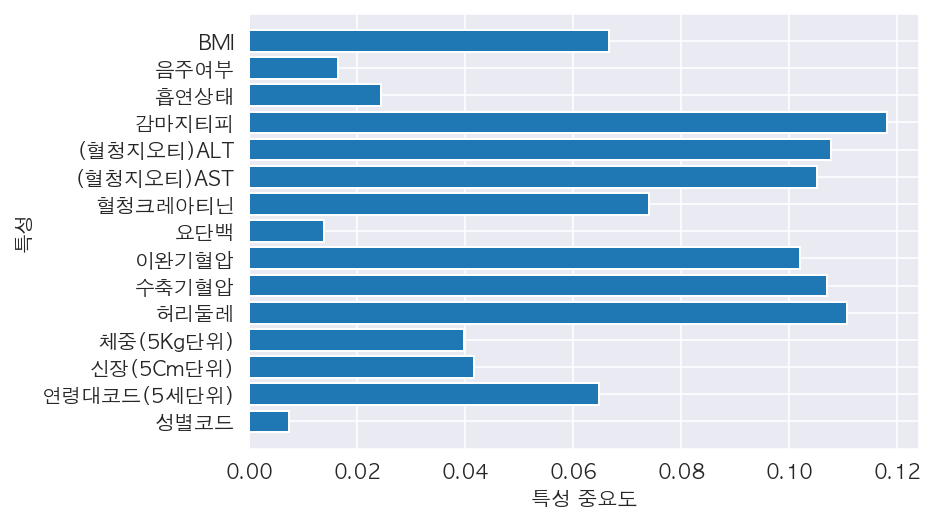

In [45]:
plot_model(forest)

## Lasso

In [46]:
from sklearn.linear_model import Lasso

lasso = Lasso(alpha=0.0001, max_iter=100000).fit(X_train, y_train)

print("TrainSet accuarcy : {:.3f}".format(lasso.score(X_train, y_train)))
print("TestSet accuarcy : {:.3f}".format(lasso.score(X_test, y_test)))

TrainSet accuarcy : 0.050
TestSet accuarcy : 0.050


In [47]:
print(lasso.coef_)

[-0.0009785   0.01076697  0.00236628 -0.00360671  0.00180979  0.00097255
 -0.00091031  0.0305589   0.00115929 -0.00074855  0.00110487  0.00053375
  0.00343108  0.          0.00882757]


라소는 이진분류 모델이 아니다.

## Logistic Regression

독립변수의 선형 결합을 이용하여 사건의 발생 가능성을 예측하는데 사용되는 통계 기법.

In [48]:
from sklearn.linear_model import LogisticRegression

In [49]:
X_train, X_test, y_train, y_test = train_test_split(X,y, random_state=42)

logR = LogisticRegression().fit(X_train, y_train)

print("TrainSet accuarcy : {:.5f}".format(logR.score(X_train, y_train)))
print("TestSet accuarcy : {:.5f}".format(logR.score(X_test, y_test)))

TrainSet accuarcy : 0.94254
TestSet accuarcy : 0.94244


In [50]:
def plot_model2(model):
    n_features = len(X.columns)
    feature_names = X.columns
    coef = np.concatenate(model.coef_).tolist()
    plt.barh(np.arange(n_features), coef, align="center")
    plt.yticks(np.arange(n_features), feature_names)
    plt.xlabel("특성 중요도")
    plt.ylabel("특성")
    plt.ylim(-1, n_features)

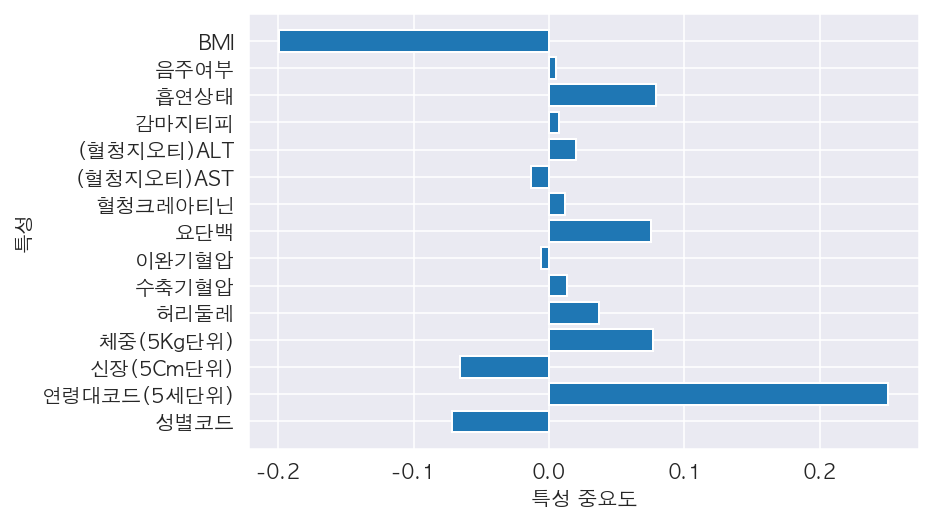

In [51]:
plot_model2(logR)

In [52]:
print(logR.coef_)

[[-0.07188588  0.25030507 -0.06601712  0.07705544  0.03726788  0.01354174
  -0.00584952  0.07520789  0.01204356 -0.0131931   0.01971123  0.00740939
   0.07870521  0.00481594 -0.19905292]]


## linearSVC (support vector classifier)

선형 서포트 벡터 머신

In [53]:
from sklearn.svm import LinearSVC

In [54]:
SVC = LinearSVC(max_iter = 5000).fit(X_train, y_train)

print("TrainSet accuarcy : {:.3f}".format(SVC.score(X_train, y_train)))
print("TestSet accuarcy : {:.3f}".format(SVC.score(X_test, y_test)))

TrainSet accuarcy : 0.943
TestSet accuarcy : 0.943


In [55]:
print(SVC.coef_)

[[-0.00608875  0.02515651  0.00517854 -0.0054089   0.00252468  0.00117039
  -0.00048421  0.06375737  0.00647263 -0.00254705  0.00378747  0.00087674
   0.01366068 -0.00129817  0.01906811]]


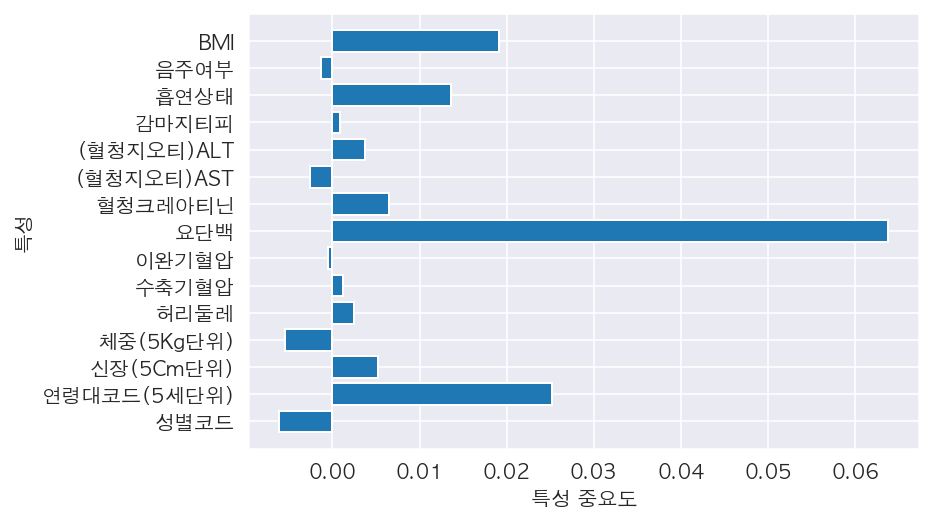

In [56]:
plot_model2(SVC)

## Lightgbm

In [57]:
from lightgbm import LGBMClassifier, plot_importance

In [58]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
x_train = sc.fit_transform(X_train)
x_test = sc.transform(X_test)

In [59]:
lgb = LGBMClassifier(n_estimators=400)
evals = [(x_test, y_test)]
lgb.fit(x_train, y_train, early_stopping_rounds=100, eval_metric="logloss",eval_set=evals, verbose=True)

[1]	valid_0's binary_logloss: 0.214989
Training until validation scores don't improve for 100 rounds
[2]	valid_0's binary_logloss: 0.211266
[3]	valid_0's binary_logloss: 0.208315
[4]	valid_0's binary_logloss: 0.2059
[5]	valid_0's binary_logloss: 0.203772
[6]	valid_0's binary_logloss: 0.201965
[7]	valid_0's binary_logloss: 0.200472
[8]	valid_0's binary_logloss: 0.199187
[9]	valid_0's binary_logloss: 0.198064
[10]	valid_0's binary_logloss: 0.19705
[11]	valid_0's binary_logloss: 0.196207
[12]	valid_0's binary_logloss: 0.195467
[13]	valid_0's binary_logloss: 0.194784
[14]	valid_0's binary_logloss: 0.19418
[15]	valid_0's binary_logloss: 0.193613
[16]	valid_0's binary_logloss: 0.193124
[17]	valid_0's binary_logloss: 0.1927
[18]	valid_0's binary_logloss: 0.192308
[19]	valid_0's binary_logloss: 0.191952
[20]	valid_0's binary_logloss: 0.191635
[21]	valid_0's binary_logloss: 0.191355
[22]	valid_0's binary_logloss: 0.191086
[23]	valid_0's binary_logloss: 0.190857
[24]	valid_0's binary_logloss: 0.

[208]	valid_0's binary_logloss: 0.187979
[209]	valid_0's binary_logloss: 0.187979
[210]	valid_0's binary_logloss: 0.18798
[211]	valid_0's binary_logloss: 0.187978
[212]	valid_0's binary_logloss: 0.187976
[213]	valid_0's binary_logloss: 0.187974
[214]	valid_0's binary_logloss: 0.187976
[215]	valid_0's binary_logloss: 0.187974
[216]	valid_0's binary_logloss: 0.187973
[217]	valid_0's binary_logloss: 0.187976
[218]	valid_0's binary_logloss: 0.187972
[219]	valid_0's binary_logloss: 0.187969
[220]	valid_0's binary_logloss: 0.187967
[221]	valid_0's binary_logloss: 0.187969
[222]	valid_0's binary_logloss: 0.187969
[223]	valid_0's binary_logloss: 0.187973
[224]	valid_0's binary_logloss: 0.187973
[225]	valid_0's binary_logloss: 0.187976
[226]	valid_0's binary_logloss: 0.187976
[227]	valid_0's binary_logloss: 0.187973
[228]	valid_0's binary_logloss: 0.187973
[229]	valid_0's binary_logloss: 0.187975
[230]	valid_0's binary_logloss: 0.187975
[231]	valid_0's binary_logloss: 0.187979
[232]	valid_0's b

LGBMClassifier(n_estimators=400)

<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

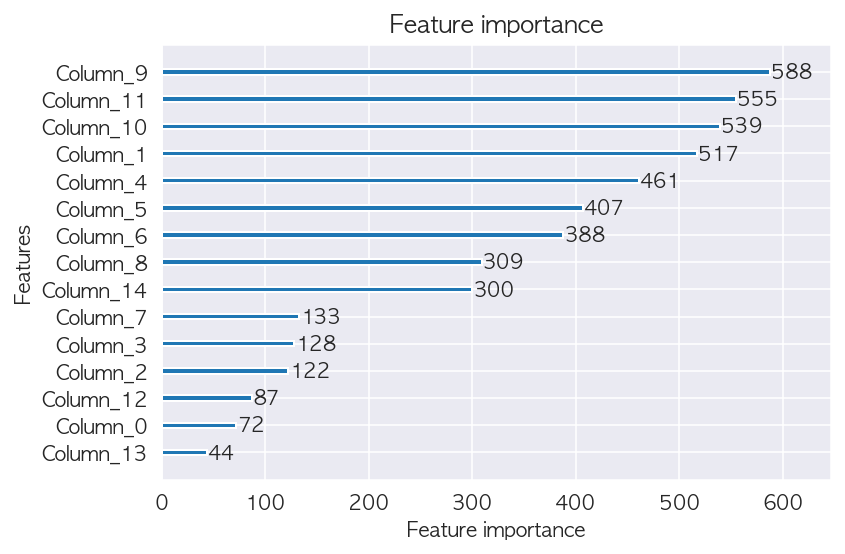

In [60]:
plot_importance(lgb)

In [61]:
print("TrainSet accuarcy : {:.5f}".format(lgb.score(X_train, y_train)))
print("TestSet accuarcy : {:.5f}".format(lgb.score(X_test, y_test)))

TrainSet accuarcy : 0.94261
TestSet accuarcy : 0.94252
